# FMCW Radar

This is an FMCW radar simulation example based on `RadarSimPy`.

`RadarSimPy` is a radar simulation package built with python. **This package is still under development by myself, and there is no plan to release it yet**.

This notebook is also available on my [GitHub](https://github.com/rookiepeng/fmcw-radar-simulation).


## FMCW Radar Model
### Transmitter

The following table lists the basic parameters of the radar transmitter.

| Parameter                       | Variable in RaSim       | Value      |
|---------------------------------|-------------------------|------------|
| Center frequency ($f_c$)        | fc                      | 24.125 GHz |
| Bandwidth ($B$)                 | bandwidth               | 100 MHz    |
| Transmitted power ($P_t$)       | tx_power                | 10 dBm     |
| Rising or falling chirp         | slop_type               | rising     |
| Chirp repetition period ($CRP$) | repetition_period       | 100 us     |
| Chirp length ($T$)              | pulse_length            | 80 us      |
| Number of chirps                | pulse_counts            | 256        |
| Chirp start delay               | delay                   | 0 s        |


In [1]:
tx = dict(
    fc=24.125e9,
    bandwidth=100e6,
    tx_power=10,
    slop_type='rising',
    repetition_period=100e-6,
    pulse_length=80e-6,
    pulse_counts=256,
    delay=0,
)

### Receiver
The parameters of the receiver are listed in the table below.

| Parameter                        | Variable in RaSim | Value        |
|----------------------------------|-------------------|--------------|
| Sampling rate ($f_s$)            | fs                | 2 Msps       |
| Noise figure ($NF$)              | noise_figure      | 12 dB        |
| RF gain/loss ($G_{rf}$)          | rf_gain           | 20 dB        |
| Load resistor ($R_L$)            | load_resistor     | 500 $\Omega$ |
| Baseband voltage gain ($G_{BB}$) | baseband_gain     | 30 dB        |
| Baseband bandwidth ($B_{BB}$)    | bandwidth         | 0.8 MHz      |

In [2]:
rx = dict(
    fs=2e6,
    noise_figure=12,
    rf_gain=20,
    baseband_gain=30,
    load_resistor=500,
    bandwidth=0.8e6,
)

### Transmitter array
The transmitter array consists of 2 antenna elements with a $2\lambda$ spacing. Both of the transmitter antenna elements have the same radiation pattern $\cos{\theta}$. The gain of the transmitter antenna elements is 6 dB.

In this simulation, assume the waves transmitted by these two transmitter antennas are perfectly orthogonal.

In [3]:
import numpy as np

wavelength = 3e8 / tx['fc']

angle = np.arange(-90, 91, 1)
pattern = 20 * np.log10(np.cos(angle / 180 * np.pi) + 0.01) + 6

tx_antenna_1 = dict(
    location=(-2 * wavelength - wavelength / 2, 0, 0),
    azimuth_angle=angle,
    azimuth_pattern=pattern,
    elevation_angle=angle,
    elevation_pattern=pattern,
)
tx_antenna_2 = dict(
    location=(-wavelength / 2, 0, 0),
    azimuth_angle=angle,
    azimuth_pattern=pattern,
    elevation_angle=angle,
    elevation_pattern=pattern,
)
tx['array'] = [tx_antenna_1, tx_antenna_2]

### Receiver array
The receiver array consists of 4 antenna elements with a $\lambda /2$ spacing. All of the receiver antenna elements have the same radiation pattern $\cos{\theta}$. The gain of the receiver antenna elements is 6 dB.

In [4]:
rx_antenna_1 = dict(
    location=(0, 0, 0),
    azimuth_angle=angle,
    azimuth_pattern=pattern,
    elevation_angle=angle,
    elevation_pattern=pattern,
)
rx_antenna_2 = dict(
    location=(wavelength / 2, 0, 0),
    azimuth_angle=angle,
    azimuth_pattern=pattern,
    elevation_angle=angle,
    elevation_pattern=pattern,
)
rx_antenna_3 = dict(
    location=(wavelength, 0, 0),
    azimuth_angle=angle,
    azimuth_pattern=pattern,
    elevation_angle=angle,
    elevation_pattern=pattern,
)
rx_antenna_4 = dict(
    location=(3 * wavelength / 2, 0, 0),
    azimuth_angle=angle,
    azimuth_pattern=pattern,
    elevation_angle=angle,
    elevation_pattern=pattern,
)
rx['array'] = [rx_antenna_1, rx_antenna_2, rx_antenna_3, rx_antenna_4]

Create the FMCW radar model based on all the parameters defined above.

In [5]:
from radarsimpy.Radar import Radar

radar = Radar(transmitter=tx, receiver=rx, type='FMCW')

Calculate the characteristics of the FMCW radar:

- Total channels: $$N_{Total}=N_{TX} \times N_{RX}$$

- Maximum range (*with I/Q baseband*): $$R_{max}=\frac{c f_s T}{2B}$$

- Maximum range (*without I/Q baseband*): $$R_{max}=\frac{c f_s T}{4B}$$

- Unambiguous velocity: $$v_{ua}=\frac{c}{2 CRP \times f_c}$$ or $$v_{ua}=\pm \frac{c}{4 CRP \times f_c}$$

- Range resolution: $$\delta_r=\frac{c}{2B}$$


In [6]:
print('Total channels: ', radar.channel_number)
print('Maximum range: ', radar.max_range)
print('Maximum unambiguous speed: ', radar.unambiguous_speed)
print('Range_resolution: ', radar.range_resolution)

Total channels:  8
Maximum range:  240.00000000000003
Maximum unambiguous speed:  62.17616580310881
Range_resolution:  1.5


### Targets
The propertities of targets are defined here. There are 3 targets in this simulation. The locations of the targets are defined through $(x, y, z)$ coordinates in meters, and the speeds of the targets are defined trough $(v_x, v_y, v_z)$ in $m/s$. The propertites of the targets also includes radar cross-section (RCS (dBsm)) and phase (radian).

In [7]:
target_1 = dict(location=(0, 200, 0), speed=(0, -5, 0), rcs=20, phase=0)
target_2 = dict(location=(0, 95, 0), speed=(0, -50, 0), rcs=15, phase=0)
target_3 = dict(location=(0, 30, 0), speed=(0, -22, 0), rcs=5, phase=0)

targets = [target_1, target_2, target_3]

In [8]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
from plotly import tools

init_notebook_mode(connected=True)

rx_loc_x = np.zeros(len(rx['array']))
rx_loc_y = np.zeros(len(rx['array']))
rx_loc_z = np.zeros(len(rx['array']))
for rx_idx, rx_element in enumerate(rx['array']):
    rx_loc_x[rx_idx] = rx_element['location'][0]
    rx_loc_y[rx_idx] = rx_element['location'][1]
    rx_loc_z[rx_idx] = rx_element['location'][2]

tx_loc_x = np.zeros(len(tx['array']))
tx_loc_y = np.zeros(len(tx['array']))
tx_loc_z = np.zeros(len(tx['array']))
for tx_idx, tx_element in enumerate(tx['array']):
    tx_loc_x[tx_idx] = tx_element['location'][0]
    tx_loc_y[tx_idx] = tx_element['location'][1]
    tx_loc_z[tx_idx] = tx_element['location'][2]

virtual_loc_x = np.zeros(radar.channel_number)
virtual_loc_y = np.zeros(radar.channel_number)
virtual_loc_z = np.zeros(radar.channel_number)
for virtual_idx, virtual_element in enumerate(
        radar.virtual_array):
    virtual_loc_x[virtual_idx] = virtual_element[0]
    virtual_loc_y[virtual_idx] = virtual_element[1]
    virtual_loc_z[virtual_idx] = virtual_element[2]

rx_axis = go.Scatter3d(
    x=rx_loc_x,
    y=rx_loc_y,
    z=rx_loc_z,
    mode='markers',
    name='Receiver',
    marker=dict(
        color='rgb(17, 157, 255)', size=8, opacity=0.8, symbol='square'),
)

tx_axis = go.Scatter3d(
    x=tx_loc_x,
    y=tx_loc_y,
    z=tx_loc_z,
    mode='markers',
    name='Transmitter',
    marker=dict(
        color='rgb(233, 30, 99)', size=8, opacity=0.8, symbol='square'),
)

virtual_axis = go.Scatter3d(
    x=virtual_loc_x,
    y=virtual_loc_y,
    z=virtual_loc_z,
    mode='markers',
    name='Virtual array',
    marker=dict(color='rgb(255, 152, 0)', size=5, opacity=1, symbol='diamond'),
)

data = [rx_axis, tx_axis, virtual_axis]

for target_idx, target in enumerate(targets):
    target_loc = go.Scatter3d(
        x=[target['location'][0]],
        y=[target['location'][1]],
        z=[target['location'][2]],
        mode='markers',
        name='Target ' + str(target_idx),
        marker=dict(size=6, opacity=0.8),
    )
    data = data + [target_loc]

camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=0, y=-1.5, z=1.8),
)

layout = go.Layout(
    title='Radar Scene',
    height=800,
    scene=dict(
        xaxis=dict(title='X (m)'),
        yaxis=dict(title='Y (m)'),
        zaxis=dict(title='Z (m)'),
        camera=camera,
        aspectmode='cube',
    ),
    margin=dict(l=0, r=0, b=120, t=120),
    legend=dict(orientation='h'),
)
fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='radar_scene.html')

## Simulate Baseband Beat Signals

Calculate beat signal matrix (beat_matrix):
$$[channel, slow~time, fast~time]$$

In [9]:
import radarsimpy.simulator as sim

data = sim.run_simulator(radar, targets)
time_matrix = data['time_matrix']
beat_matrix = data['beat_matrix']

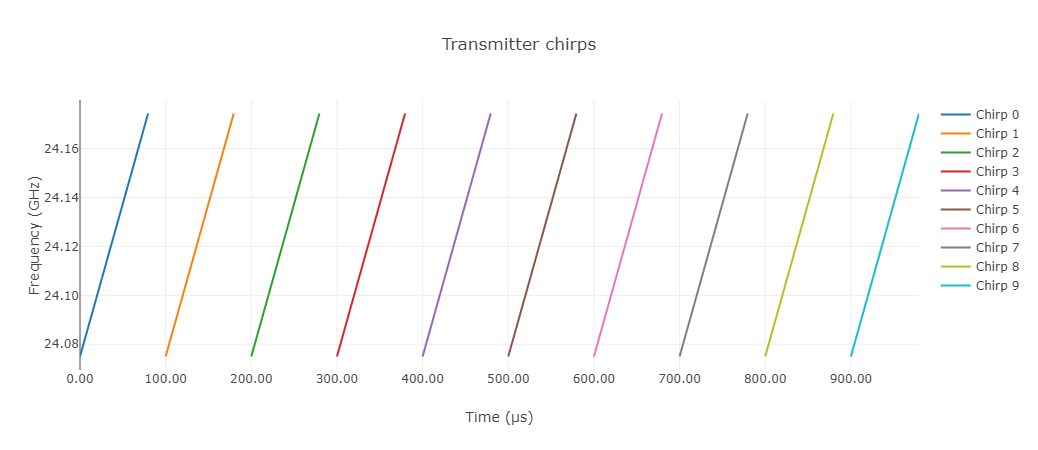

In [10]:
samples_per_chirp = int(tx['pulse_length'] * rx['fs'])

data = []
for idx in range(0, 10):
    chirp = go.Scatter(
        x=time_matrix[0, idx, :] * 1e6,
        y=np.linspace(
            tx['fc'] - tx['bandwidth'] / 2,
            tx['fc'] + tx['bandwidth'] / 2,
            samples_per_chirp,
            endpoint=False,
        ) / 1e9,
        name='Chirp ' + str(idx),
    )
    data = data + [chirp]

layout = go.Layout(
    title='Transmitter chirps',
    yaxis=dict(tickformat='.2f', title='Frequency (GHz)'),
    xaxis=dict(tickformat='.2f', title='Time (µs)'),
)

fig = go.Figure(data, layout=layout)
iplot(fig, filename='chirps.html')

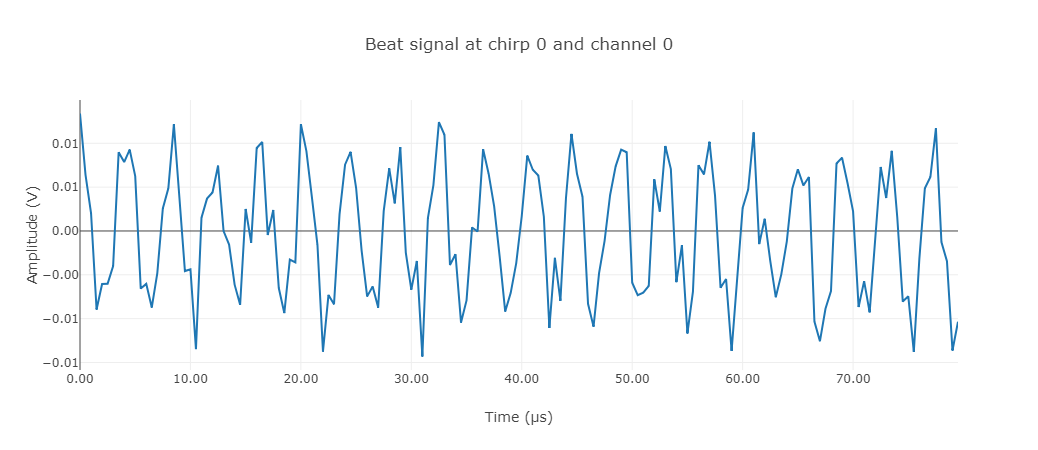

In [11]:
beat = go.Scatter(
    x=time_matrix[0, 0, :] * 1e6,
    y=np.real(beat_matrix[0, 0, :]),
    name='Beat signal at chirp 0 and channel 0',
)
data = [beat]

layout = go.Layout(
    title='Beat signal at chirp 0 and channel 0',
    yaxis=dict(tickformat='.2f', title='Amplitude (V)'),
    xaxis=dict(tickformat='.2f', title='Time (µs)'),
)

fig = go.Figure(data, layout=layout)
iplot(fig, filename='beat.html')

## Radar Signal Processing
### Range profile

In [12]:
from scipy import signal
import radarsimpy.processing as proc

range_window = signal.chebwin(radar.receiver.samples_per_pulse, at=60)
range_profile = proc.range_profile(radar, beat_matrix, range_window)

In [13]:
temp = np.abs(range_profile[0, :, :])
temp = 20 * np.log10(temp + 0.001)

range_axis = np.linspace(
    0,
    radar.max_range,
    radar.receiver.samples_per_pulse,
    endpoint=False)

doppler_axis = np.linspace(
    0, tx['pulse_counts'], tx['pulse_counts'], endpoint=False)

data = [go.Surface(x=range_axis, y=doppler_axis, z=temp, colorscale='Rainbow')]

layout = go.Layout(
    title='Range Profile',
    height=800,
    scene=dict(
        xaxis=dict(title='Range (m)'),
        yaxis=dict(title='Chirp'),
        zaxis=dict(title='Amplitude (dB)'),
        aspectmode='cube',
    ),
    margin=dict(l=0, r=0, b=60, t=100),
    legend=dict(orientation='h'),
)

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='range_profile.html')

### Range-Doppler processing

In [14]:
doppler_window = signal.chebwin(tx['pulse_counts'], at=60)
range_doppler = proc.range_doppler(
    radar, range_profile, doppler_window, fft_shift=False)

In [15]:
temp = np.abs(range_doppler[0, :, :])
temp = 20 * np.log10(temp)

range_axis = np.linspace(
    0,
    radar.max_range,
    radar.receiver.samples_per_pulse,
    endpoint=False)

doppler_axis = np.linspace(
    -radar.unambiguous_speed,
    0,
    tx['pulse_counts'],
    endpoint=False)

data = [go.Surface(x=range_axis, y=doppler_axis, z=temp, colorscale='Rainbow')]

layout = go.Layout(
    title='Range Doppler',
    height=800,
    scene=dict(
        xaxis=dict(title='Range (m)'),
        yaxis=dict(title='Velocity (m/s)'),
        zaxis=dict(title='Amplitude (dB)'),
        aspectmode='cube',
    ),
    margin=dict(l=0, r=0, b=60, t=100),
    legend=dict(orientation='h'),
)

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='range_doppler.html')